**Chapter 13 – Convolutional Neural Networks**

_This notebook is based on the sample code in chapter 13._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from io import open

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    print("to: ", path)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [3]:
import tensorflow as tf

# Convolutional layer

In TensorFlow, each input image is typically represented as a 3D tensor of shape \[height, width, channels\] . A mini-batch is represented as a 4D tensor of shape \[mini-batch size, height, width, channels\]. he weights of a convolutional layer are represented as a 4D tensor of shape \[fh , fw , fn , fn′ \]. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape \[fn \].

Let’s look at a simple example. 

The following code loads two sample images, using Scikit-Learn’s load_sample_images() (which loads two color images, one of a Chinese temple, and the other of a flower). 

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

# lets single out the china image for now
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)



Now let's creates two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line).

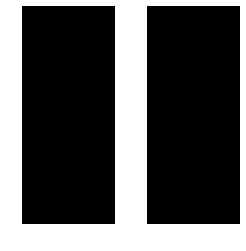

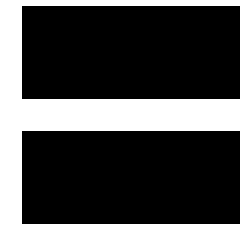

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

**QUESTION**: What do you think will happen when we apply these filters? What types of features are we trying to emphasize with each of these filters?

Now we can apply these filters to the china image using a convolutional layer built using TensorFlow’s conv2d() function (with zero padding and a stride of 2 ).

In [6]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

 Finally, we can plot the oringal image and the resulting feature maps. We will also save them to make sure this functionality is working (you may need to be able to do this later for your own projects).

Saving figure china_original
to:  /home/jblankenburg/cs791-mlapps/deepML/images/china_original.png


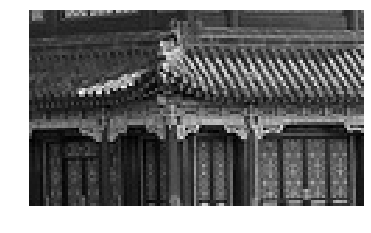

In [8]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical
to:  /home/jblankenburg/cs791-mlapps/deepML/images/china_vertical.png


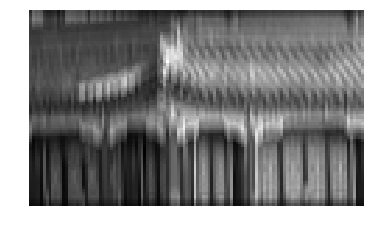

In [9]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal
to:  /home/jblankenburg/cs791-mlapps/deepML/images/china_horizontal.png


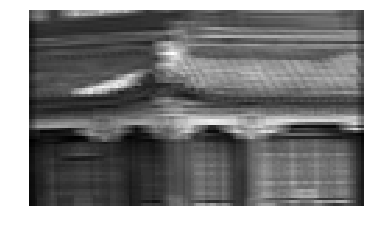

In [10]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

Now that we have seen all the parts, lets put them all together in a easier to read chunk. We will now look at both the china and flower images.

## Simple example

In [11]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})


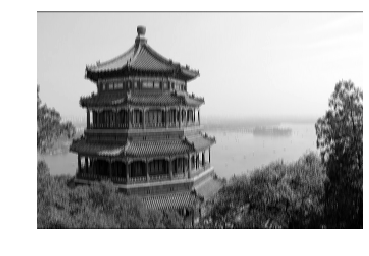

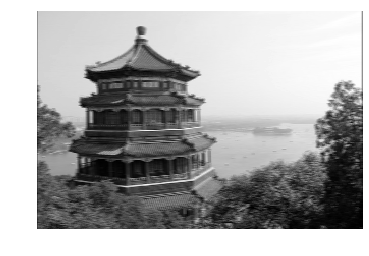

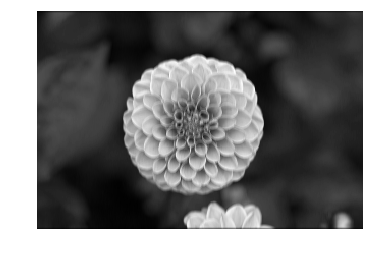

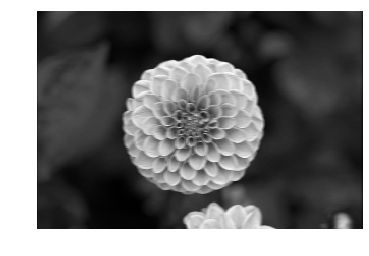

In [12]:
# plot the feature map outputs:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

**QUESTION:** Describe how each feature map affected these two pictures. Did the feature maps emphasize the features that you expected?
_NOTE: It might be helpful to plot the original images here to compare to._

There is another way to create this same type of convolutional layer without having to manually specify the filters we are applying by using a different package in TF. Here we show how to do the same thing 
using `tf.layers.conv2d()`:

In [13]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

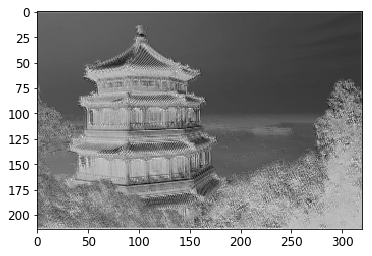

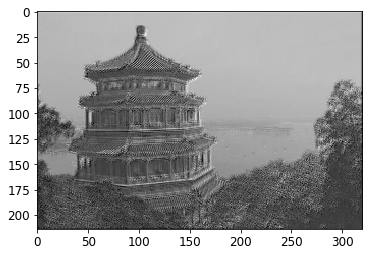

In [15]:
plt.imshow(output[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
plt.show()
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()


**QUESTION:** Do the filters applied here work better or worse than the filters we defined manually? Why do you think this is?

## VALID vs SAME padding

If we set the padding to "VALID", the convolutional layer does **not** use zero padding, and may ignore some rows and columns at the bottom and right of the imput image, depending on the stride.

If we set the padding to "SAME", the convolutional layer does use zero padding if necessary. In this case, the number of output neurons is equal to the number of input neurons divided by the stride, rounded up. Then
zeros are added as evenly as possible around the inputs.

Let's take a look at how these different padding schemes change the size of a simple image.

In [16]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [17]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


**QUESTION:** What is the above code doing? Can you explain why the SAME padding has three ouputs after the convolusion instead of just two like VALID does?

# Pooling layer

Once you understand how convolutional layers work, the pooling layers are quite easy to grasp. Their goal is to _subsample_ (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting). Reducing the input image size also makes the neural network tolerate a little bit of image shift (_location invariance_).

A pooling layer typically works on every input channel independently, so the output depth is the same as the input depth.

Let's take a look at how we can implement a max pooling layer in TF. The following code creates a max pooling layer using a 2 × 2 kernel, stride 2, and no padding, then applies it to all the images in the dataset:

In [18]:
# batch_size, height, width, channels = dataset.shape

# filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
# filters[:, 3, :, 0] = 1  # vertical line
# filters[3, :, :, 1] = 1  # horizontal line

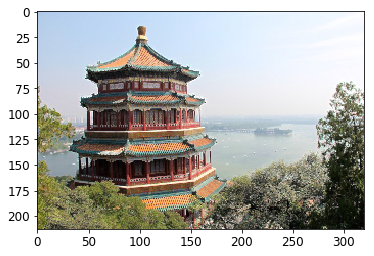

In [ ]:
batch_size, height, width, channels = dataset.shape

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

Saving figure china_original
to:  /home/jblankenburg/cs791-mlapps/deepML/images/china_original.png


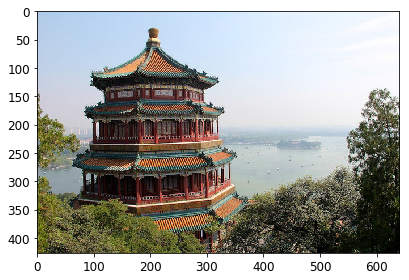

Saving figure china_max_pool
to:  /home/jblankenburg/cs791-mlapps/deepML/images/china_max_pool.png


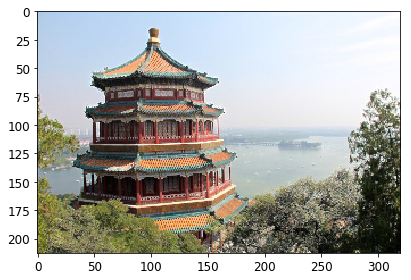

Saving figure flower_original
to:  /home/jblankenburg/cs791-mlapps/deepML/images/flower_original.png


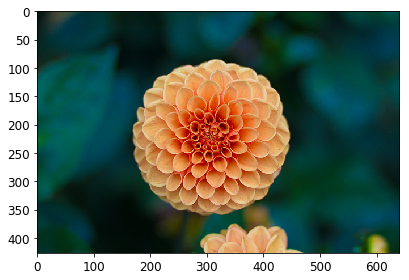

Saving figure flower_max_pool
to:  /home/jblankenburg/cs791-mlapps/deepML/images/flower_max_pool.png


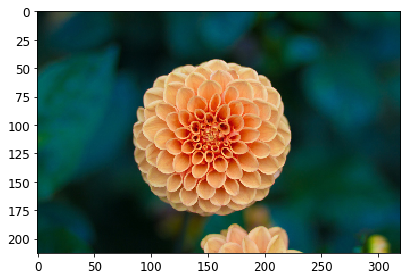

In [ ]:
plot_color_image(dataset[0])
save_fig("china_original")
plt.axis("on")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.axis("on")
plt.show()

plot_color_image(dataset[1])
save_fig("flower_original")
plt.axis("on")
plt.show()

plot_color_image(output[1])
save_fig("flower_max_pool")
plt.axis("on")
plt.show()

**Question:** What changed in the images after applying max pooling? Do you think the max pooling saved enough details about the images?

# MNIST

Note: instead of using the `fully_connected()`, `conv2d()` and `dropout()` functions from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()`, `conv2d()` and `dropout()` functions (respectively) from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

For all these functions:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).

The other main differences in `tf.layers.dense()` are:
* the `weights` parameter was renamed to `kernel` (and the weights variable is now named `"kernel"` rather than `"weights"`),
* the default activation is `None` instead of `tf.nn.relu`

The other main differences in `tf.layers.conv2d()` are:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the default `activation` is now `None` instead of `tf.nn.relu`.

The other main differences in `tf.layers.dropout()` are:
* it takes the dropout rate (`rate`) rather than the keep probability (`keep_prob`). Of course, `rate == 1 - keep_prob`,
* the `is_training` parameters was renamed to `training`.

In [ ]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


**QUESTION:** Breifly explain what the above code does. _HINT: Are the layers being defined connected?_

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [ ]:
# Set up the training and testing data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
# Train the model 
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9779
1 Last batch accuracy: 0.98 Test accuracy: 0.9838
2 Last batch accuracy: 0.98 Test accuracy: 0.9778
3 Last batch accuracy: 0.98 Test accuracy: 0.9879
4 Last batch accuracy: 0.99 Test accuracy: 0.9879
5 Last batch accuracy: 1.0 Test accuracy: 0.9887
6 Last batch accuracy: 1.0 Test accuracy: 0.9897
7 Last batch accuracy: 1.0 Test accuracy: 0.9898


**QUESTION:** How well did this model perform on MNIST? 